In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 

In [2]:
import os

# Define the directory path
new_directory = r'C:\Users\jason'

# Change the current directory to the new directory
os.chdir(new_directory)

# Verify the current directory has been changed
current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: C:\Users\jason


In [3]:
# read the data file
df = pd.read_csv("gas_prod.csv")

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [5]:
# Assume the sequence starts in January 2004 and ends in December 2023 (12 months x 20 years)
start_date = '2004-01'

# Generate a date range starting from the start_date, with a frequency of one month,
# and length equal to the dataset
df['Date'] = pd.date_range(start=start_date, periods=len(df), freq='M')

In [6]:
# Convert data to time series
gasprod_ts = pd.Series(df.Gas_prod.values, index=df.Date, name='Gas_prod')

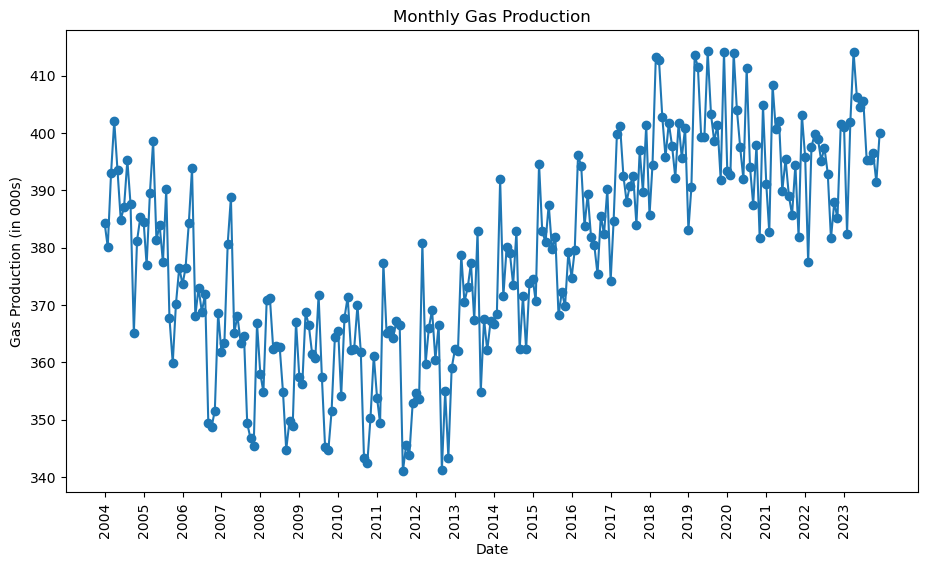

In [7]:
# Plotting
plt.figure(figsize=(11, 6))  # Adjust size if needed
plt.plot(df['Date'], df['Gas_prod'], marker='o', linestyle='-')

# Labeling the plot
plt.title('Monthly Gas Production')
plt.xlabel('Date')
plt.ylabel('Gas Production (in 000s)')

# Customizing x-axis tick labels to show every year
plt.xticks(df['Date'][::12], [date.year for date in df['Date'][::12]], rotation=90)

plt.show()

In [8]:
# Dickey-Fuller Test to verify whether a time-series is stationary
# Null hypothesis: Series is non-stationary
# p-vlaue: non-significance indicating non-stationary
# Test Statistic > Critical Value: Reject null hypothesis and conclude Series is stationary

from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(gasprod_ts.values[1:],autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', '#lags used', 'Number of observations Used'])

for key , value in dftest[4].items(): dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.664424
p-value                          0.855751
#lags used                      15.000000
Number of observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


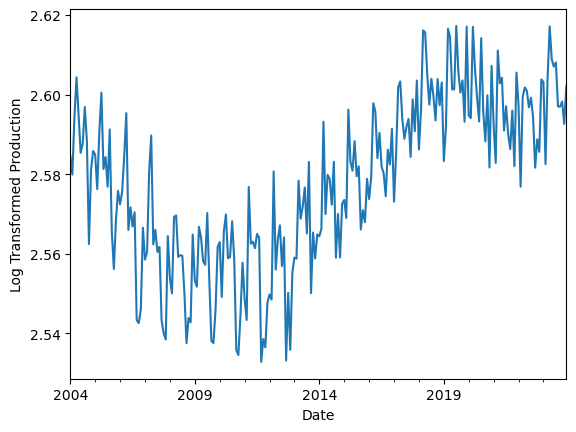

In [9]:
# Log transformation to achieve constant variance
import numpy as np
gasprod_ts_log = np.log10(gasprod_ts)
ax = gasprod_ts_log.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Log Transformed Production')
plt.show()

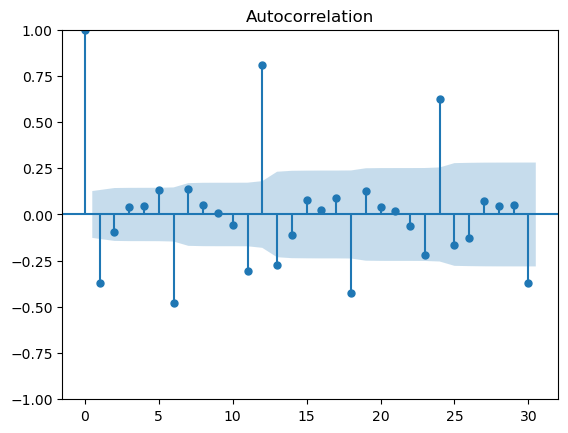

In [10]:
# Plot ACF to check potential seasonality
# ACF: autocorrelation factor
import statsmodels.tsa.api as smt
gasprod_ts_log_diff = gasprod_ts_log.diff(periods= 1)
gasprod_ts_log_diff.dropna(inplace=True)
smt.graphics.plot_acf(gasprod_ts_log_diff, lags=30, alpha= 0.05)
plt.show()

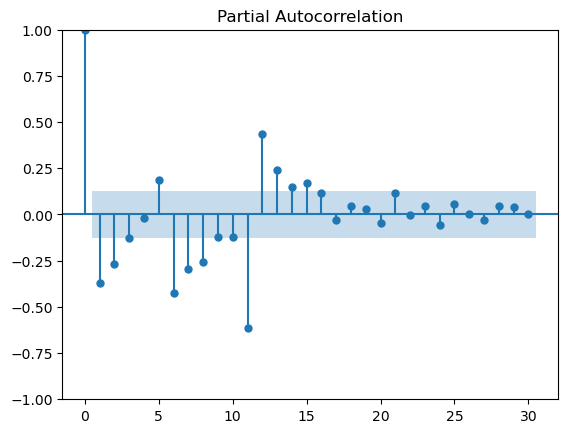

In [11]:
# PACF plot to show significant lags
smt.graphics.plot_pacf(gasprod_ts_log_diff, lags=30, alpha= 0.05)
plt.show()

In [12]:
# Data partition for the time series data
# Keep the last three years data as the validation dataset
nValid = 36
nTrain = len(gasprod_ts_log) - nValid
train_ts = gasprod_ts_log[:nTrain]
valid_ts = gasprod_ts_log[nTrain:]

In [13]:
# Test a SARIMA model
import statsmodels.api as sm
temp_model = sm.tsa.statespace.SARIMAX(train_ts,
                                       order=(1,1,1),
                                       seasonal_order=(1,0,1,12),
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)
results = temp_model.fit()
print(results.summary())

C:\Users\jason\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\jason\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           Gas_prod   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 750.040
Date:                            Fri, 19 Apr 2024   AIC                          -1490.080
Time:                                    14:59:36   BIC                          -1473.514
Sample:                                01-31-2004   HQIC                         -1483.378
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0084      0.109     -0.077      0.939      -0.223       0.206
ma.L1         -0.7019      0.072   

In [14]:
# Forecast with the fitted model
pred = results.get_forecast(steps=36,alpha=0.05)

# Forecasted values
forecasted_values = pred.predicted_mean

# Confidence intervals for the forecasted values
confidence_intervals = pred.conf_int()

# Print the forecasted values
print("Forecasted values:")
print(forecasted_values)

# Print the confidence intervals
print("\n95% confidence intervals:")
print(confidence_intervals)

Forecasted values:
2021-01-31    2.588064
2021-02-28    2.587300
2021-03-31    2.607063
2021-04-30    2.597712
2021-05-31    2.591711
2021-06-30    2.586278
2021-07-31    2.604512
2021-08-31    2.588300
2021-09-30    2.581867
2021-10-31    2.592102
2021-11-30    2.576193
2021-12-31    2.598326
2022-01-31    2.581837
2022-02-28    2.581180
2022-03-31    2.598182
2022-04-30    2.590137
2022-05-31    2.584974
2022-06-30    2.580301
2022-07-31    2.595987
2022-08-31    2.582040
2022-09-30    2.576506
2022-10-31    2.585311
2022-11-30    2.571625
2022-12-31    2.590665
2023-01-31    2.576480
2023-02-28    2.575914
2023-03-31    2.590541
2023-04-30    2.583620
2023-05-31    2.579179
2023-06-30    2.575158
2023-07-31    2.588653
2023-08-31    2.576654
2023-09-30    2.571893
2023-10-31    2.579468
2023-11-30    2.567694
2023-12-31    2.584075
Freq: M, Name: predicted_mean, dtype: float64

95% confidence intervals:
            lower Gas_prod  upper Gas_prod
2021-01-31        2.576772        2.5

C:\Users\jason\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
